In [ ]:
import kagglehub

# Download
path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")

print("Dataset baixado em:", path)

#https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/data

Using Colab cache for faster access to the 'cbis-ddsm-breast-cancer-image-dataset' dataset.
Dataset baixado em: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset


**Parte 1**

Verifica o caminho da pasta

In [1]:
from google.colab import drive
import os

# Monta o Google Drive na máquina virtual do Colab
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'

if os.path.exists(zip_path):
    print("Arquivo zip encontrado com sucesso!")
else:
    print(f"ERRO: Não encontrei o arquivo em {zip_path}. Verifique o nome da pasta/arquivo no Drive.")

Mounted at /content/drive
Arquivo zip encontrado com sucesso!


**Parte 1.1**

Encontra as imagens e combina com as informações (rótulos) do arquivo de metadados (CSV) para que o programa possa aprender com elas.


In [ ]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- 1. CONFIGURAÇÃO E EXTRAÇÃO ---
# Caminho da imagem
ZIP_PATH = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'
EXTRACT_PATH = '/content/dados_extraidos'

if not os.path.exists(EXTRACT_PATH):
    print(f"Descompactando {ZIP_PATH}...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Descompactação concluída.")
    except Exception as e:
        print(f"Erro ao descompactar: {e}")
        exit() # Para se der erro
else:
    print("Arquivos já descompactados anteriormente.")

# --- 2. MAPEAMENTO E PREPARAÇÃO DO DATASET (MODO POR PASTA/UID) ---
print("Localizando e processando metadados (CSVs)...")

csv_train = glob.glob(os.path.join(EXTRACT_PATH, "**", "mass_case_description_train_set.csv"), recursive=True)
csv_test = glob.glob(os.path.join(EXTRACT_PATH, "**", "mass_case_description_test_set.csv"), recursive=True)

if not csv_train:
    raise FileNotFoundError("CSV de treino não encontrado.")

df = pd.read_csv(csv_train[0])
if csv_test:
    df_test = pd.read_csv(csv_test[0])
    df = pd.concat([df, df_test], ignore_index=True)

# Mapeamento de Classes
def get_article_label(pathology):
    if 'MALIGNANT' in pathology: return 'Malignant'
    if 'BENIGN_WITHOUT_CALLBACK' in pathology: return 'Normal'
    if 'BENIGN' in pathology: return 'Benign'
    return None

df['label'] = df['pathology'].apply(get_article_label)
df = df.dropna(subset=['label'])

# --- INDEXA POR NOME DA PASTA (UID) ---
print("Indexando imagens pelo ID da pasta...")
folder_map = {}

# Varre todas as pastas e guarda onde estão as imagens JPG
for root, dirs, files in os.walk(EXTRACT_PATH):
    # Filtra apenas arquivos de imagem
    images_in_folder = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if images_in_folder:
        # O nome da pasta atual (aquele numero 1.3.6.1.4...) será a chave
        folder_name = os.path.basename(root)

        # Guarda o caminho completo das imagens dessa pasta
        full_paths = [os.path.join(root, img) for img in images_in_folder]
        folder_map[folder_name] = full_paths

print(f"Total de pastas com imagens encontradas: {len(folder_map)}")

# Cruzamento CSV <-> Imagem
valid_data = []
print("Cruzando dados (Buscando ID da pasta do CSV no disco)...")

for idx, row in df.iterrows():
    # Preferência: Imagem Recortada (ROI) > Imagem Completa
    # O CSV tem caminhos tipo: "Mass-Training_.../1.3.6.1.4.1...UID.../000000.dcm"
    paths_to_try = [row.get('cropped image file path'), row.get('image file path')]

    found_filepath = None

    for csv_path in paths_to_try:
        if pd.isna(csv_path): continue

        # Quebra o caminho do CSV em partes (separado por /)
        # Ex: ['Mass-Training...', '1.3.6.1.4.1.9590...', '1.3.6.1.4.1.9590...', '000000.dcm']
        path_parts = csv_path.split('/')

        # Verifica se alguma parte desse caminho corresponde a uma pasta que achamos no disco
        for part in path_parts:
            if part in folder_map:
                candidates = folder_map[part]

                # SE TIVER MAIS DE UMA IMAGEM NA PASTA (Caso da sua imagem 3: ROI + Máscara)
                # Pega a maior imagem (geralmente a textura do ROI é maior que a máscara binária)
                if len(candidates) > 1:
                    try:
                        # Pega o arquivo com maior tamanho em bytes (evita pegar a máscara preta)
                        found_filepath = max(candidates, key=os.path.getsize)
                    except:
                        found_filepath = candidates[0]
                else:
                    found_filepath = candidates[0]

                break

        if found_filepath: break

    if found_filepath:
        valid_data.append({'filepath': found_filepath, 'label': row['label']})

df_final = pd.DataFrame(valid_data)

# --- VERIFICAÇÃO FINAL ---
if len(df_final) == 0:
    print("\nERRO CRÍTICO PERSISTE.")
    print("Debug - Chaves encontradas no disco (exemplo):", list(folder_map.keys())[:3])
    print("Debug - Caminho no CSV (exemplo):", df.iloc[0]['image file path'])
    raise ValueError("Não foi possível casar as pastas do CSV com as pastas do disco.")

print(f"SUCESSO! Total de imagens vinculadas: {len(df_final)}")
print("Distribuição:\n", df_final['label'].value_counts())

Descompactando /content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip...
Descompactação concluída.
Localizando e processando metadados (CSVs)...
Indexando imagens pelo ID da pasta...
Total de pastas com imagens encontradas: 6774
Cruzando dados (Buscando ID da pasta do CSV no disco)...
SUCESSO! Total de imagens vinculadas: 1696
Distribuição:
 label
Malignant    784
Benign       771
Normal       141
Name: count, dtype: int64


In [ ]:
df_final.head()

,filepath,label
0,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
1,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
2,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
3,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
4,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign


**Parte 2**

Filtro para termos apenas as bases quase balanceadas devida a mesma quantidade entre dados de maligno e benigno

In [ ]:
df_final_binario = df_final[df_final['label'] != 'Normal']

# Reseta o índice
df_final_binario = df_final_binario.reset_index(drop=True)

print(f"Total de imagens restantes: {len(df_final_binario)}")
print("Nova distribuição:\n", df_final_binario['label'].value_counts())

Total de imagens restantes: 1555
Nova distribuição:
 label
Malignant    784
Benign       771
Name: count, dtype: int64


In [ ]:
df_final_binario.head()

,filepath,label
0,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
1,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Malignant
2,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
3,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign
4,/content/dados_extraidos/jpeg/1.3.6.1.4.1.9590...,Benign


**Imagem Original**

ROI mask images: o desenho do local do tumor

Visualizando 5 imagens aleatórias dos dados de leitura...


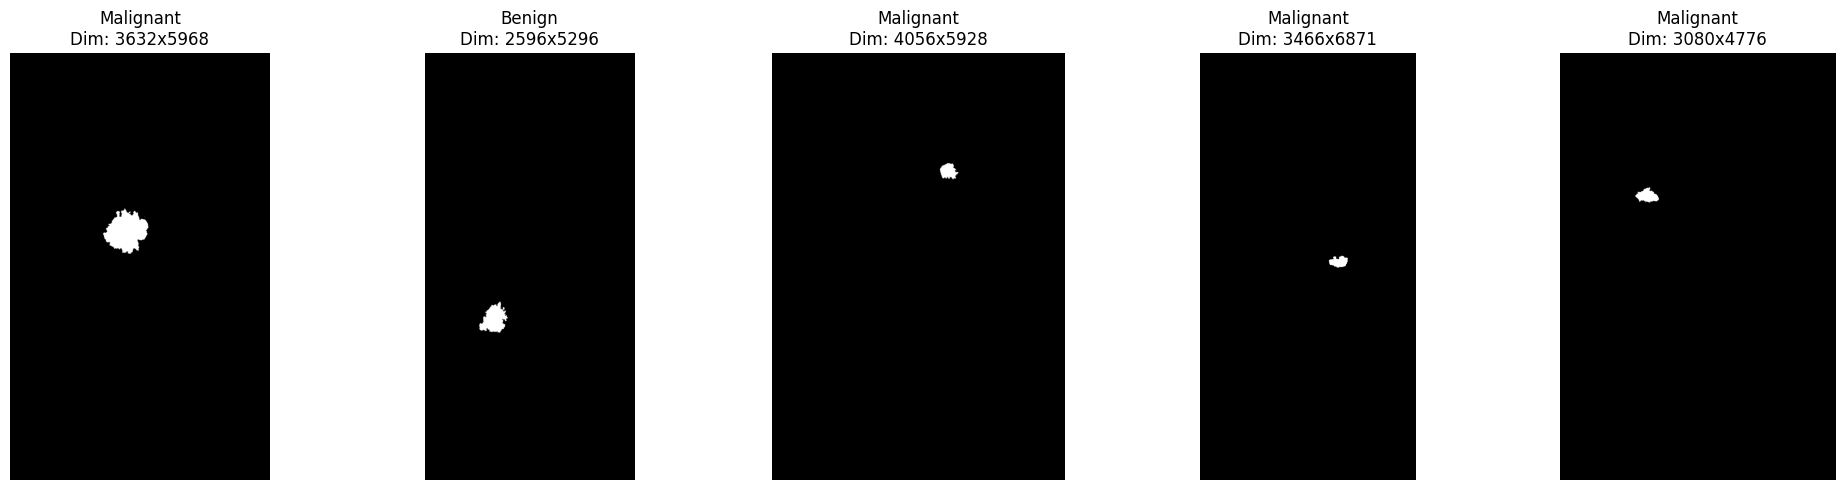

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def visualizar_amostra_leitura(df, num_samples=5):
    # Seleciona índices aleatórios
    indices = np.random.choice(df.index, num_samples, replace=False)

    plt.figure(figsize=(20, 5))

    for i, idx in enumerate(indices):
        caminho = df.loc[idx, 'filepath']
        rotulo = df.loc[idx, 'label']

        # Leitura da imagem
        img = cv2.imread(caminho)

        if img is not None:
            # OpenCV carrega em BGR (Azul-Verde-Vermelho) e convertemos para RGB para o Matplotlib
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            altura, largura, canais = img.shape

            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img_rgb)
            plt.title(f"{rotulo}\nDim: {largura}x{altura}")
            plt.axis('off')
        else:
            print(f"Erro ao ler a imagem no índice {idx}: {caminho}")

    plt.tight_layout()
    plt.show()

# Chama a função
print("Visualizando 5 imagens aleatórias dos dados de leitura...")
visualizar_amostra_leitura(df_final_binario)




**Contraponto com relação ao Artigo**

Comparação de redes (criar hipótese não é boa, para isso comparar, ou pode ser a base, parametros, aumento)

 ver com outras arquiteturas e aumento da

 # Artigos novos

 https://www.mdpi.com/2075-4418/15/22/2829  (pago para publicar)

 https://pmc.ncbi.nlm.nih.gov/articles/PMC9208612/

 # Artigo a ser estudado será que a rede é ruim? ou é a base que é ruim? (hipótese)

https://www.techscience.com/iasc/v32n2/45574/html

# Ver as estruturas da mama
# Virar um contraponto
# Aumento de dados igual ao artigo
# Pegar os mesmos parametros do artigo e ver com outras redes


# Referencias de outras redes para testar (3.2) Ver arquiteturas que possa comprar e redes do artigo

**Divisão Treino e Teste**

In [ ]:
# Divisão Treino/Teste
train_df, val_df = train_test_split(df_final_binario, test_size=0.3, stratify=df_final_binario['label'], random_state=42)
print(f"Treino: {len(train_df)} | Teste/Validação: {len(val_df)}")

Treino: 1088 | Teste/Validação: 467


**Parte 3**

In [ ]:
import cv2
import pywt
import numpy as np
from skimage.restoration import wiener
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence, to_categorical

# --- 3. PIPELINE DE PRÉ-PROCESSAMENTO E GERADORES ---

# Definição das funções de filtro
def process_pipeline(image_path):
    # Leitura
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return np.zeros((224,224,3))

    # Redimensiona
    img = cv2.resize(img, (224, 224))

    # A) Otsu Thresholding
    blur = cv2.GaussianBlur(img, (5, 5), 0) # para remover ruídos pequenos
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.bitwise_and(img, img, mask=mask)

    # B) Wiener Filter
    img = img.astype(np.float64) / 255.0
    psf = np.ones((5, 5)) / 25
    img = wiener(img, psf, balance=0.2)
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    # C) CLAHE Filter
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # D) Wavelet Packet Decomposition (db3, nível 2)
    coeffs = pywt.wavedec2(img, 'db3', level=2)
    coeffs[1] = tuple([np.zeros_like(v) for v in coeffs[1]]) # Suavização
    img = pywt.waverec2(coeffs, 'db3')
    img = np.clip(img, 0, 255).astype(np.uint8)

    # Converte para RGB
    img = cv2.resize(img, (224, 224))
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) / 255.0

# Classe do Gerador (2 CLASSES)
class DDSMGenerator(Sequence):
    def __init__(self, df, batch_size=10):
        self.df = df
        self.batch_size = batch_size
        self.le = LabelEncoder()

        # O LabelEncoder mapeia automaticamente: Benign -> 0, Malignant -> 1
        self.df['enc'] = self.le.fit_transform(self.df['label'])

        #  2 classes
        self.n_classes = 2
        self.indices = np.arange(len(self.df))

        # Guardar o mapeamento para conferência
        self.class_map = dict(zip(self.le.classes_, self.le.transform(self.le.classes_)))
        print(f"Mapeamento de Classes gerado: {self.class_map}")

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[indices]
        X, y = [], []
        for _, row in batch_data.iterrows():
            processed_img = process_pipeline(row['filepath'])
            X.append(processed_img)
            y.append(row['enc'])

        # um_classes=2 (pq não tem mais Classe Normal)
        return np.array(X), to_categorical(y, num_classes=2)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Instancia os geradores
print("Criando geradores de dados...")
# Adicionado a Divisão do que é Treino e Validação/Teste
print("Gerador de Treino -------")
train_gen = DDSMGenerator(train_df, batch_size=10)
print("Gerador de Validação/Teste -------")
val_gen = DDSMGenerator(val_df, batch_size=10)
print("Geradores prontos!")

Criando geradores de dados...
Gerador de Treino -------
Mapeamento de Classes gerado: {'Benign': np.int64(0), 'Malignant': np.int64(1)}
Gerador de Validação/Teste -------
Mapeamento de Classes gerado: {'Benign': np.int64(0), 'Malignant': np.int64(1)}
Geradores prontos!


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.metrics import AUC

# --- 4. REDE NEURAL E TREINAMENTO (GOOGLE NET + ADAM) ---
print("\nInicializando GoogleNet (InceptionV3)...")

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # usar para Data augmentation(no conjunto de Treinamento e testar com Taxa de aprendizado 1000 e 10000 e com 50 épocas)
x = Dense(1024, activation='relu')(x)

# Dados binário, por isso 2
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilação
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

print("Iniciando treinamento...")

# Treinamento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    verbose=1
)

print("Treinamento concluído.")


Inicializando GoogleNet (InceptionV3)...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Iniciando treinamento...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 816s 7s/step - accuracy: 0.5538 - auc: 0.5619 - loss: 0.7430 - val_accuracy: 0.4957 - val_auc: 0.5237 - val_loss: 0.7465
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 733s 7s/step - accuracy: 0.5950 - auc: 0.6294 - loss: 0.6898 - val_accuracy: 0.5609 - val_auc: 0.5666 - val_loss: 0.6857
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 748s 7s/step - accuracy: 0.5888 - auc: 0.5999 - loss: 0.6942 - val_accuracy: 0.5087 - val_auc: 0.5326 - val_loss: 0.7084
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 741s 7s/step - accuracy: 0.6153 - auc: 0.6627 - loss: 0.6500 - val_accuracy: 0.5391 - val_auc: 0.5560 - val_loss: 0.7504
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 733s 7s/step - accuracy: 0.6263 - auc: 0.6670 - loss: 0.6602 - val_accuracy: 0.5348 - val_auc: 0.5645 - val_loss: 0.8761
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 751s 7s/step - accuracy: 0.6522 - auc: 0.7189 - loss: 0.6121 - val_accuracy: 0.4978 - val_auc: 0.5413 - val_loss: 0.7500
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━

**Parte com época 50, Aumento de Dados de Treino e Taxa de Treinamento 0.0001**

In [ ]:
import cv2
import pywt
import numpy as np
import tensorflow as tf
from skimage.restoration import wiener
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. FUNÇÕES DE PRÉ-PROCESSAMENTO  ---
# Remoção de fundo -> Wiener Filter -> CLAHE -> Wavelet db3

def process_pipeline(image_path):
    # Leitura
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return np.zeros((224,224,3))

    # Redimensiona
    img = cv2.resize(img, (224, 224))

    # A) Otsu Thresholding (Remoção de Fundo)
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.bitwise_and(img, img, mask=mask)

    # B) Wiener Filter (Remoção de Ruído)
    img = img.astype(np.float64) / 255.0
    psf = np.ones((5, 5)) / 25
    img = wiener(img, psf, balance=0.2)
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    # C) CLAHE Filter (Contraste)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # D) Wavelet Packet Decomposition (db3, nível 2)
    coeffs = pywt.wavedec2(img, 'db3', level=2)
    coeffs[1] = tuple([np.zeros_like(v) for v in coeffs[1]]) # Suavização
    img = pywt.waverec2(coeffs, 'db3')
    img = np.clip(img, 0, 255).astype(np.uint8)

    # Converte para RGB
    img = cv2.resize(img, (224, 224))
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) / 255.0

# --- 2. DATA AUGMENTATION ---
def apply_augmentation(img):
    rows, cols, _ = img.shape
    if np.random.rand() > 0.5: # Metade das imagens de treino serão espelhadas horizontalmente e a outra metade ficará normal. Isso cria variedade sem distorcer todo o dataset.
        img = cv2.flip(img, 1)

    # Rotação
    angle = np.random.uniform(-20, 20)
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows))
    return img

# --- 3. CLASSE DO GERADOR ---
class DDSMGenerator(Sequence):
    def __init__(self, df, batch_size=4, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.augment = augment
        self.le = LabelEncoder()
        # Garante que 'label' existe e mapeia
        self.df['enc'] = self.le.fit_transform(self.df['label'])
        self.indices = np.arange(len(self.df))

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size] # [0:4], [4:8]
        batch_data = self.df.iloc[indices]
        X, y = [], []
        for _, row in batch_data.iterrows():
            processed_img = process_pipeline(row['filepath']) # chama função 1

            if self.augment:
                processed_img = apply_augmentation(processed_img) # chama função 2

            X.append(processed_img)
            y.append(row['enc'])

        return np.array(X), to_categorical(y, num_classes=2)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- 4. MODELO E TREINAMENTO ---
print("Inicializando GoogleNet (InceptionV3)...")

# Define InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congela base
print("Congelando camadas da base...")
for layer in base_model.layers:
    layer.trainable = False

# Cabeça da rede
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # No artigo se usou camada de dropout com 50% de probabilidade para a GoogleNet. Essa camada "desliga" aleatoriamente 50% dos neurônios daquela camada a cada passo.
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compila
print("Compilando o modelo...")
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

# Instancia Geradores
print("Configurando geradores...")
train_gen = DDSMGenerator(train_df, batch_size=4, augment=True) # Chama função 3
val_gen   = DDSMGenerator(val_df, batch_size=4, augment=False)

# Treina
print("\nIniciando treinamento...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('melhor_modelo_google_net.keras', save_best_only=True, monitor='val_loss')
    ]
)
print("Treinamento finalizado.")

Inicializando GoogleNet (InceptionV3)...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Congelando camadas da base...
Compilando o modelo...
Configurando geradores...

Iniciando treinamento...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.5338 - auc: 0.5247 - loss: 0.8424 - val_accuracy: 0.5409 - val_auc: 0.5863 - val_loss: 0.7937
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 256s 941ms/step - accuracy: 0.5674 - auc: 0.5821 - loss: 0.7963 - val_accuracy: 0.5216 - val_auc: 0.5518 - val_loss: 0.7332
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 265s 973ms/step - accuracy: 0.5561 - auc: 0.5874 - loss: 0.7418 - val_accuracy: 0.5517 - val_auc: 0.5860 - val_loss: 0.6926
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 253s 932ms/step - accuracy: 0.5755 - auc: 0.6122 - loss: 0.7078 - val_accuracy: 0.5841 - val_auc: 0.5892 - val_loss: 0.6933
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 258s 948ms/step - accuracy: 0.5917 - auc: 0.6220 - loss: 0.6818 - val_accuracy: 0.5625 - val_auc: 0.6046 - val_loss: 0.6715
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 257s 947ms/step - accuracy: 0.5752 - auc: 0.6205 - loss: 0.6858 - val_accuracy: 0.5647 - val_auc: 0.6115 - val_loss: 0.6668
Epoch 7/50
272/272 

In [ ]:
import cv2
import pywt
import numpy as np
import tensorflow as tf
from skimage.restoration import wiener
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. FUNÇÕES DE PRÉ-PROCESSAMENTO  ---
# Remoção de fundo -> Wiener Filter -> CLAHE -> Wavelet db3

def process_pipeline(image_path):
    # Leitura
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return np.zeros((224,224,3))

    # Redimensiona
    img = cv2.resize(img, (224, 224))

    # A) Otsu Thresholding (Remoção de Fundo)
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.bitwise_and(img, img, mask=mask)

    # B) Wiener Filter (Remoção de Ruído)
    img = img.astype(np.float64) / 255.0
    psf = np.ones((5, 5)) / 25
    img = wiener(img, psf, balance=0.2)
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    # C) CLAHE Filter (Contraste)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # D) Wavelet Packet Decomposition (db3, nível 2)
    coeffs = pywt.wavedec2(img, 'db3', level=2)
    coeffs[1] = tuple([np.zeros_like(v) for v in coeffs[1]]) # Suavização
    img = pywt.waverec2(coeffs, 'db3')
    img = np.clip(img, 0, 255).astype(np.uint8)

    # Converte para RGB
    img = cv2.resize(img, (224, 224))
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) / 255.0

# --- 2. DATA AUGMENTATION ---
def apply_augmentation(img):
    rows, cols, _ = img.shape
    if np.random.rand() > 0.5: # Flip
        img = cv2.flip(img, 1)

    # Rotação
    angle = np.random.uniform(-20, 20)
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows))
    return img

# --- 3. CLASSE DO GERADOR ---
class DDSMGenerator(Sequence):
    def __init__(self, df, batch_size=4, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.augment = augment
        self.le = LabelEncoder()
        # Garante que 'label' existe e mapeia
        self.df['enc'] = self.le.fit_transform(self.df['label'])
        self.indices = np.arange(len(self.df))

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[indices]
        X, y = [], []
        for _, row in batch_data.iterrows():
            processed_img = process_pipeline(row['filepath']) # chama função de pre processamento

            if self.augment:
                processed_img = apply_augmentation(processed_img) # chama função de aumento de dados em treino

            X.append(processed_img)
            y.append(row['enc'])

        return np.array(X), to_categorical(y, num_classes=2)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- 4. MODELO E TREINAMENTO ---
print("Inicializando GoogleNet (InceptionV3)...")

# Define InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congela base
print("Congelando camadas da base...")
for layer in base_model.layers:
    layer.trainable = False

# Cabeça da rede
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compila
print("Compilando o modelo...")
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

# Instancia Geradores
print("Configurando geradores...")
train_gen = DDSMGenerator(train_df, batch_size=4, augment=True)
val_gen   = DDSMGenerator(val_df, batch_size=4, augment=False)

# Treina
print("\nIniciando treinamento...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('melhor_modelo_google_net.keras', save_best_only=True, monitor='val_loss')
    ]
)
print("Treinamento finalizado.")

Com Fine-Tuning

Normalização

In [ ]:
import cv2
import pywt
import numpy as np
import tensorflow as tf
from skimage.restoration import wiener
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. FUNÇÕES DE PRÉ-PROCESSAMENTO  ---
def process_pipeline(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return np.zeros((224,224,3))

    img = cv2.resize(img, (224, 224))

    # A) Otsu Thresholding
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.bitwise_and(img, img, mask=mask)

    # B) Wiener Filter
    img = img.astype(np.float64) / 255.0
    psf = np.ones((5, 5)) / 25
    img = wiener(img, psf, balance=0.2)
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    # C) CLAHE Filter
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # D) Wavelet
    coeffs = pywt.wavedec2(img, 'db3', level=2)
    coeffs[1] = tuple([np.zeros_like(v) for v in coeffs[1]])
    img = pywt.waverec2(coeffs, 'db3')
    img = np.clip(img, 0, 255).astype(np.uint8)

    # Converte para RGB e redimensiona
    img = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # --- NORMALIZAÇÃO ---
    # InceptionV3 espera input entre -1 e 1, não 0 e 1.
    # Fórmula: (Imagem / 127.5) - 1.0
    return (img_rgb.astype(np.float32) / 127.5) - 1.0

# --- 2. DATA AUGMENTATION ---
# Fazer mais aumentos
# Tirar a Hibernação
def apply_augmentation(img):
    rows, cols, _ = img.shape
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)

    # Rotação leve
    angle = np.random.uniform(-15, 15) # Reduzi um pouco para não perder bordas
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)
    return img

# --- 3. CLASSE DO GERADOR (Mantida igual, apenas garantindo batch size) ---
class DDSMGenerator(Sequence):
    def __init__(self, df, batch_size=8, augment=False):  # tambanho lote
        self.df = df
        self.batch_size = batch_size
        self.augment = augment
        self.le = LabelEncoder()
        self.df['enc'] = self.le.fit_transform(self.df['label'])
        self.indices = np.arange(len(self.df))

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[indices]
        X, y = [], []
        for _, row in batch_data.iterrows():
            processed_img = process_pipeline(row['filepath']) # chama função 1
            if self.augment:
                processed_img = apply_augmentation(processed_img) # chama função 2
            X.append(processed_img)
            y.append(row['enc'])
        return np.array(X), to_categorical(y, num_classes=2)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- 4. MODELO E TREINAMENTO (COM FINE-TUNING) ---
print("Inicializando GoogleNet (InceptionV3)...")

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# --- ESTRATÉGIA DE FINE-TUNING ---
# 1. Congela as primeiras camadas (que detectam bordas simples)
# 2. Descongela as ÚLTIMAS camadas (que detectam formas complexas)
# O InceptionV3 tem 311 camadas. Se treina as últimas 60.
print("Configurando Fine-Tuning (Descongelando topo da rede)...")

for layer in base_model.layers[:249]: # Congela até a camada 249
    layer.trainable = False
for layer in base_model.layers[249:]: # Treina da 249 até o fim
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilação
print("Compilando o modelo...")
# Tamanho do Lote
BATCH_SIZE = 8
# 10k
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

print(f"Configurando geradores (Batch Size: {BATCH_SIZE})...")
train_gen = DDSMGenerator(train_df, batch_size=BATCH_SIZE, augment=True) # chama função 3
val_gen   = DDSMGenerator(val_df, batch_size=BATCH_SIZE, augment=False)

print("\nIniciando treinamento...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    verbose=1,
    callbacks=[
        # Aumentei a paciência para 12 para dar mais tempo de adaptação ao fine-tuning
        EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
        ModelCheckpoint('melhor_modelo_google_net.keras', save_best_only=True, monitor='val_loss')
    ]
)
print("Treinamento finalizado.")

Inicializando GoogleNet (InceptionV3)...
Configurando Fine-Tuning (Descongelando topo da rede)...
Compilando o modelo...
Configurando geradores (Batch Size: 8)...

Iniciando treinamento...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.5336 - auc: 0.5518 - loss: 0.7950 - val_accuracy: 0.5323 - val_auc: 0.5584 - val_loss: 0.7293
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.5695 - auc: 0.5737 - loss: 0.7201 - val_accuracy: 0.5733 - val_auc: 0.6108 - val_loss: 0.7010
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.6004 - auc: 0.6415 - loss: 0.6683 - val_accuracy: 0.5776 - val_auc: 0.6251 - val_loss: 0.6757
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.5653 - auc: 0.6028 - loss: 0.6849 - val_accuracy: 0.5603 - val_auc: 0.5967 - val_loss: 0.6836
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.5548 - auc: 0.5884 - loss: 0.6895 - val_accuracy: 0.5474 - val_auc: 0.5889 - val_loss: 0.7261
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.5679 - auc: 0.6095 - loss: 0.6800 - val_accuracy: 0.5582 - val_auc: 0.5848 - val_loss: 0.6999
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━

In [ ]:
import cv2
import pywt
import numpy as np
import tensorflow as tf
from skimage.restoration import wiener
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- CONFIGURAÇÃO GLOBAL ---
IMG_SIZE = 299  # Tamanho nativo da InceptionV3
BATCH_SIZE = 8  # Lote

# --- 1. FUNÇÃO AUXILIAR: RESIZE COM PADDING (EVITA DISTORÇÃO) ---
def resize_with_padding(img, target_size):
    """Redimensiona mantendo a proporção e preenche o resto com preto."""
    h, w = img.shape[:2]
    scale = min(target_size/w, target_size/h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h))

    # Cria quadro preto
    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Coloca a imagem no centro
    new_img = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return new_img

# --- 2. PIPELINE DE PRÉ-PROCESSAMENTO ---
def process_pipeline(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return np.zeros((IMG_SIZE, IMG_SIZE, 3))

    # Pré-resize para acelerar filtros se a imagem for gigante (>1024px)
    h, w = img.shape
    if h > 1024:
        img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)

    # A) Otsu
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.bitwise_and(img, img, mask=mask)

    # B) Wiener
    img = img.astype(np.float64) / 255.0
    psf = np.ones((5, 5)) / 25
    img = wiener(img, psf, balance=0.2)
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    # C) CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # D) Wavelet
    coeffs = pywt.wavedec2(img, 'db3', level=2)
    coeffs[1] = tuple([np.zeros_like(v) for v in coeffs[1]])
    img = pywt.waverec2(coeffs, 'db3')
    img = np.clip(img, 0, 255).astype(np.uint8)

    # Converte para RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # APLICA O RESIZE (299x299 com bordas pretas)
    img_final = resize_with_padding(img_rgb, IMG_SIZE)

    # Normalização (-1 a 1)
    return (img_final.astype(np.float32) / 127.5) - 1.0

# --- 3. DATA AUGMENTATION ---
def apply_augmentation(img):
    rows, cols, _ = img.shape
    if np.random.rand() > 0.5: img = cv2.flip(img, 1)

    # Rotação (com borda preta para não estragar o padding)
    angle = np.random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=[0,0,0])
    return img

# --- 4. CLASSE DO GERADOR ---
class DDSMGenerator(Sequence):
    def __init__(self, df, batch_size=8, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.augment = augment
        self.le = LabelEncoder()
        self.df['enc'] = self.le.fit_transform(self.df['label'])
        self.indices = np.arange(len(self.df))

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[indices]
        X, y = [], []
        for _, row in batch_data.iterrows():
            processed_img = process_pipeline(row['filepath']) # Chama função 2
            if self.augment:
                processed_img = apply_augmentation(processed_img) # Chama função 3
            X.append(processed_img)
            y.append(row['enc'])
        return np.array(X), to_categorical(y, num_classes=2)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- 5. MODELO E TREINAMENTO ---
print(f"Inicializando InceptionV3 com entrada {IMG_SIZE}x{IMG_SIZE}...")

# Input shape recebe a variável IMG_SIZE (299)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# ESTRATÉGIA: Descongelar mais camadas para aprender detalhes médicos
print("Descongelando as últimas 60 camadas...")
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
# BatchNormalization ajuda a estabilizar o treino
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

print("Compilando...")
# Se usa 0.0001. Se travar, o ReduceLROnPlateau vai diminuir automaticamente.
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

print(f"Geradores (Batch Size: {BATCH_SIZE})...")
train_gen = DDSMGenerator(train_df, batch_size=BATCH_SIZE, augment=True)
val_gen   = DDSMGenerator(val_df, batch_size=BATCH_SIZE, augment=False)

print("\nIniciando treinamento...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50, # Mais de 30 épocas
    verbose=1,
    callbacks=[
        # Se o erro parar de cair por 3 épocas, diminui a velocidade de aprendizado
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
        ModelCheckpoint('melhor_modelo_inception_299.keras', save_best_only=True, monitor='val_loss')
    ]
)

Inicializando InceptionV3 com entrada 299x299...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Descongelando as últimas 60 camadas...
Compilando...
Geradores (Batch Size: 8)...

Iniciando treinamento...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2664s 19s/step - accuracy: 0.5152 - auc: 0.5204 - loss: 1.1242 - val_accuracy: 0.5388 - val_auc: 0.5841 - val_loss: 0.7152 - learning_rate: 1.0000e-04
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2625s 19s/step - accuracy: 0.5416 - auc: 0.5861 - loss: 0.9372 - val_accuracy: 0.5668 - val_auc: 0.5776 - val_loss: 1.1318 - learning_rate: 1.0000e-04
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2598s 19s/step - accuracy: 0.5471 - auc: 0.5830 - loss: 0.8889 - val_accuracy: 0.5216 - val_auc: 0.5554 - val_loss: 1.3878 - learning_rate: 1.0000e-04
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5427 - auc: 0.5816 - loss: 0.8523 
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
136/136 ━━━━━━━━━━━━━━━━━━━━ 2590s 19s/step - accuracy: 0.5427 - auc: 0.5816 - loss: 0.8523 - val_accuracy: 0.5000 - val_auc: 0.5230 - val_loss: 3.3941 - learning_rate: 1.0000e-04
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2563s 19s/step - accuracy: 0.5

**Outro**

**Overfitting (Sobreajuste)**

A partir da época 12, a rede começou a "decorar" as imagens de treino (especialmente as repetidas da classe Normal) em vez de aprender os padrões gerais.

In [ ]:
# --- 4. REDE NEURAL E TREINAMENTO (GOOGLE NET + ADAM) ---
print("\nInicializando GoogleNet (InceptionV3)...")

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilação: Adam com LR=0.0001
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Iniciando treinamento com dataset balanceado (1950 amostras)...")

# Treinamento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15, # Artigo usou até 100 iterações/épocas
    verbose=1
)

print("Treinamento concluído.")


Inicializando GoogleNet (InceptionV3)...
Iniciando treinamento com dataset balanceado (1950 amostras)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3897 - loss: 1.1359

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 857s 6s/step - accuracy: 0.3900 - loss: 1.1355 - val_accuracy: 0.4241 - val_loss: 1.1640
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 801s 6s/step - accuracy: 0.5174 - loss: 0.9867 - val_accuracy: 0.4983 - val_loss: 0.9821
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 786s 6s/step - accuracy: 0.6026 - loss: 0.8236 - val_accuracy: 0.5362 - val_loss: 0.8799
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 818s 6s/step - accuracy: 0.6039 - loss: 0.7907 - val_accuracy: 0.5310 - val_loss: 0.9732
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 807s 6s/step - accuracy: 0.6274 - loss: 0.7505 - val_accuracy: 0.5655 - val_loss: 0.8934
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 803s 6s/step - accuracy: 0.6833 - loss: 0.6681 - val_accuracy: 0.6172 - val_loss: 0.7900
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 857s 6s/step - accuracy: 0.6916 - loss: 0.6317 - val_accuracy: 0.5707 - val_loss: 1.0297
Epoch 8/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 797s 6s/step - accuracy: 0.7516 - loss: 0.5610 - val_accuracy: 0.598

A rede aprendeu muito bem! Ela saiu de 36% para 95% no conjunto de treino. Isso prova que a arquitetura GoogleNet + Adam funciona e tem capacidade de aprender as características do câncer.

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

print("\nInicializando GoogleNet (InceptionV3) para Fine-Tuning...")

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 1. Descongelar as camadas do topo da GoogleNet
# As primeiras camadas congeladas (traços básicos) e treinar as últimas (formas complexas)
for layer in base_model.layers[:249]:
   layer.trainable = False
for layer in base_model.layers[249:]:
   layer.trainable = True

# 2. Recompilar com Learning Rate MUITO baixo
# Mantém Adam mas se reduz drasticamente o LR para não destruir o que já aprendeu.
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Iniciando Fine-Tuning (Descongelando camadas finais)...")

# 3. Continuar o treinamento
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    verbose=1
)


Inicializando GoogleNet (InceptionV3) para Fine-Tuning...
Iniciando Fine-Tuning (Descongelando camadas finais)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.3616 - loss: 1.1253 - val_accuracy: 0.4310 - val_loss: 1.0373
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.5159 - loss: 1.0012 - val_accuracy: 0.5672 - val_loss: 0.9228
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5833 - loss: 0.9005 - val_accuracy: 0.6310 - val_loss: 0.8410
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.6606 - loss: 0.7806 - val_accuracy: 0.6328 - val_loss: 0.7766
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.6870 - loss: 0.7193 - val_accuracy: 0.6397 - val_loss: 0.7163
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.7551 - loss: 0.5827 - val_accuracy: 0.6569 - val_loss: 0.6979
Epoch 7/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.7938 - loss: 0.5146 - val_accuracy: 0.6655 - val_loss: 0.6683
Epoch 8/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.8385 - loss: 0.4220 - val_accu

Data Augmentation

Pós Geradores Prontos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- NOVO GERADOR COM DATA AUGMENTATION ---
# Para combater o overfitting

class AugmentedDDSMGenerator(Sequence):
    def __init__(self, df, batch_size=10, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.augment = augment
        self.le = LabelEncoder()
        self.df['enc'] = self.le.fit_transform(self.df['label'])
        self.indices = np.arange(len(self.df))

        # Configuramos as distorções (rotação, zoom, flip)
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=20,      # Gira até 20 graus
                width_shift_range=0.1,  # Move horizontalmente
                height_shift_range=0.1, # Move verticalmente
                shear_range=0.1,        # Inclina
                zoom_range=0.1,         # Zoom leve
                horizontal_flip=True,   # Espelha
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[indices]

        X, y = [], []
        for _, row in batch_data.iterrows():
            # 1. Processa a imagem (Wiener, CLAHE, etc)
            img = process_pipeline(row['filepath'])
            X.append(img)
            y.append(row['enc'])

        X = np.array(X)
        y = to_categorical(y, num_classes=3)

        # 2. Se for treino, aplica a distorção aleatória na imagem processada
        if self.augment:
            # O flow do Keras espera 4D array, fazemos um truque para aplicar no batch
            iter_batch = self.datagen.flow(X, y, batch_size=self.batch_size, shuffle=False)
            return next(iter_batch)

        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Recriar os geradores
print("Recriando geradores com Data Augmentation...")
# Treino COM aumento de dados
train_gen_aug = AugmentedDDSMGenerator(train_df, batch_size=10, augment=True)
# Validação SEM aumento (queremos testar na imagem real)
val_gen_aug = AugmentedDDSMGenerator(val_df, batch_size=10, augment=False)
print("Pronto para re-treinar.")

Recriando geradores com Data Augmentation...
Pronto para re-treinar.


**Exração de imagem**

In [3]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np

# --- 1. CONFIGURAÇÃO E EXTRAÇÃO ---
ZIP_PATH = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'
EXTRACT_PATH = '/content/dados_extraidos'

if not os.path.exists(EXTRACT_PATH):
    print(f"Descompactando {ZIP_PATH}...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Descompactação concluída.")
    except Exception as e:
        print(f"Erro ao descompactar: {e}")
        # exit() # Comentado para rodar no notebook sem fechar o kernel
else:
    print("Arquivos já descompactados.")

# --- 2. MAPEAMENTO UNIFICADO (MASSAS + CALCIFICAÇÕES) ---
print("Localizando e processando metadados...")

# Padrão para pegar TODOS os CSVs de treino e teste (Mass e Calc)
# Baseado na sua imagem
csv_files = glob.glob(os.path.join(EXTRACT_PATH, "**", "*_case_description_*.csv"), recursive=True)

if not csv_files:
    raise FileNotFoundError("Nenhum CSV encontrado!")

print(f"CSVs encontrados: {[os.path.basename(f) for f in csv_files]}")

# Lê e junta todos os CSVs em um único DataFrame
df_list = []
for f in csv_files:
    try:
        df_temp = pd.read_csv(f)
        df_list.append(df_temp)
    except:
        pass

if df_list:
    df = pd.concat(df_list, ignore_index=True)
else:
    raise ValueError("Erro ao ler CSVs.")

# Mapeamento de Classes
def get_article_label(pathology):
    # Garante que é string para evitar erro
    pathology = str(pathology).upper()
    if 'MALIGNANT' in pathology: return 'Malignant'
    if 'BENIGN' in pathology: return 'Benign' # Inclui Benign_without_callback como Benign se quiser, ou Normal
    return 'Normal' # O resto vira Normal

df['label'] = df['pathology'].apply(get_article_label)

# --- FILTRO BINÁRIO (IMPORTANTE PARA SUA ACURÁCIA) ---
# Benigno vs Maligno (2 classes), remove-se os Normais
df = df[df['label'] != 'Normal']
print(f"Total de casos (Benigno + Maligno): {len(df)}")

# --- 3. INDEXAÇÃO INTELIGENTE ---
print("Indexando imagens pelo ID da pasta...")
folder_map = {}

for root, dirs, files in os.walk(EXTRACT_PATH):
    # Filtra imagens
    images_in_folder = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if images_in_folder:
        folder_name = os.path.basename(root)
        full_paths = [os.path.join(root, img) for img in images_in_folder]
        folder_map[folder_name] = full_paths

# --- 4. CRUZAMENTO DE DADOS (COM A LÓGICA DE TAMANHO) ---
valid_data = []
print("Cruzando CSV com Imagens...")

for idx, row in df.iterrows():
    # Tenta ROI primeiro, depois imagem completa
    paths_to_try = [row.get('cropped image file path'), row.get('image file path')]
    found_filepath = None

    for csv_path in paths_to_try:
        if pd.isna(csv_path): continue

        # Pega as partes do caminho (UIDs)
        path_parts = str(csv_path).split('/')

        for part in path_parts:
            if part in folder_map:
                candidates = folder_map[part]

                # --- SUA LÓGICA VENCEDORA AQUI ---
                # Se tiver máscara e imagem, pega a maior (Imagem)
                if len(candidates) > 1:
                    try:
                        found_filepath = max(candidates, key=os.path.getsize)
                    except:
                        found_filepath = candidates[0]
                else:
                    found_filepath = candidates[0]

                break
        if found_filepath: break

    if found_filepath:
        valid_data.append({'filepath': found_filepath, 'label': row['label']})

df_final = pd.DataFrame(valid_data)

# Reset index para garantir limpeza
df_final = df_final.reset_index(drop=True)

print(f"\nSUCESSO FINAL! Imagens vinculadas: {len(df_final)}")
print("Distribuição:\n", df_final['label'].value_counts())

Arquivos já descompactados.
Localizando e processando metadados...
CSVs encontrados: ['calc_case_description_train_set.csv', 'mass_case_description_train_set.csv', 'mass_case_description_test_set.csv', 'calc_case_description_test_set.csv']
Total de casos (Benigno + Maligno): 3568
Indexando imagens pelo ID da pasta...
Cruzando CSV com Imagens...

SUCESSO FINAL! Imagens vinculadas: 3568
Distribuição:
 label
Benign       2111
Malignant    1457
Name: count, dtype: int64


Verificando 5 imagens sorteadas do total de 3568...


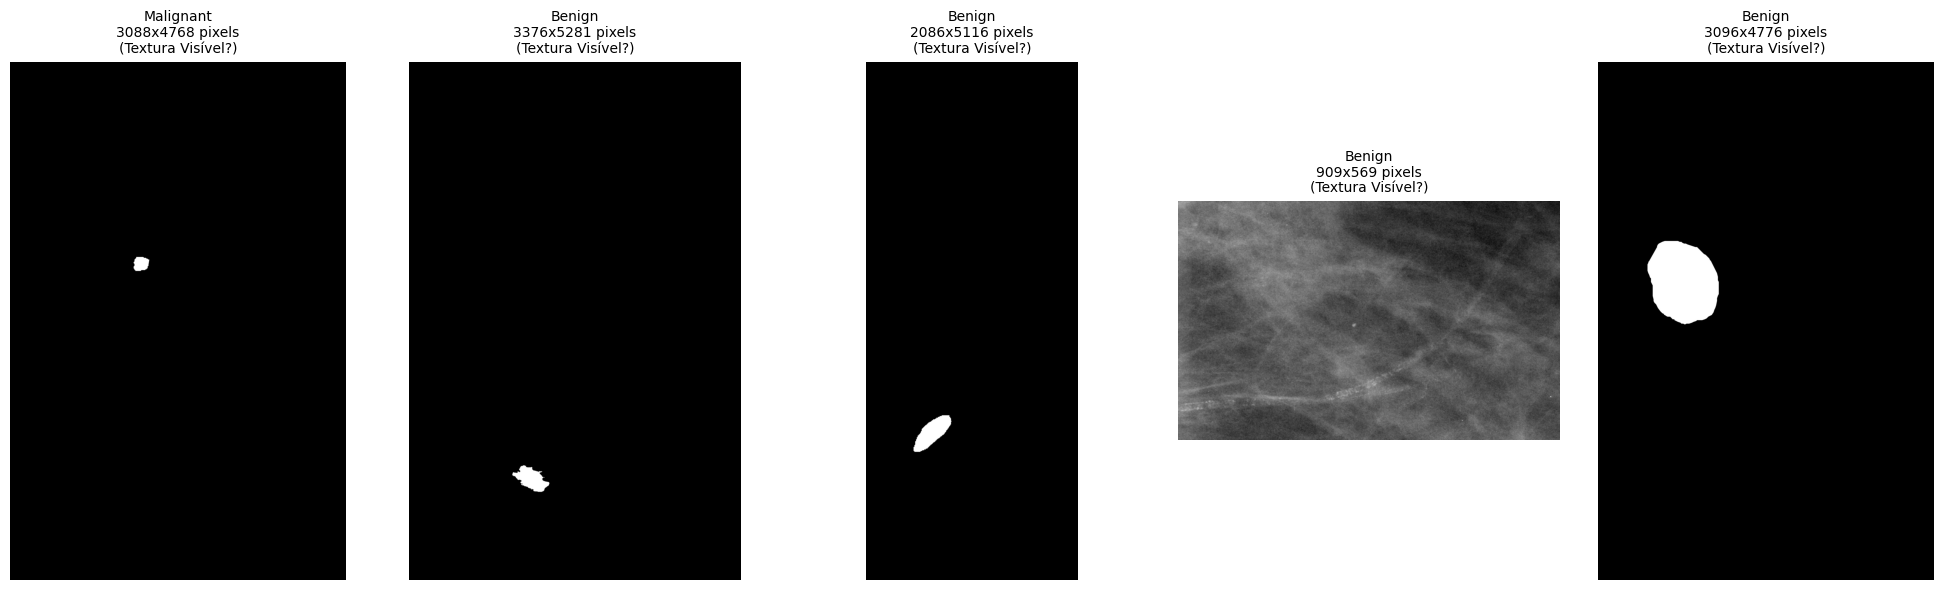

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualizar_amostra_final(df, num_samples=5):
    # Garante que não vamos pedir mais amostras do que existem
    num_samples = min(num_samples, len(df))

    # Sorteia índices aleatórios
    indices = np.random.choice(df.index, num_samples, replace=False)

    plt.figure(figsize=(20, 6))

    for i, idx in enumerate(indices):
        caminho = df.loc[idx, 'filepath']
        rotulo = df.loc[idx, 'label']

        # Lê a imagem
        img = cv2.imread(caminho)

        plt.subplot(1, num_samples, i + 1)

        if img is not None:
            # Converte BGR (OpenCV) para RGB (Matplotlib)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Pega dimensões
            h, w, c = img.shape

            plt.imshow(img_rgb)
            plt.title(f"{rotulo}\n{w}x{h} pixels\n(Textura Visível?)", fontsize=10)
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, "Erro ao ler", ha='center')
            plt.title(f"{rotulo}\n(Caminho inválido)")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- EXECUÇÃO ---
print(f"Verificando 5 imagens sorteadas do total de {len(df_final)}...")
visualizar_amostra_final(df_final)

In [ ]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

# --- 1. CONFIGURAÇÃO ---
ZIP_PATH = '/content/drive/MyDrive/Unifesp/Projeto_Cancer/archive.zip'
EXTRACT_PATH = '/content/dados_extraidos'

if not os.path.exists(EXTRACT_PATH):
    print(f"Descompactando {ZIP_PATH}...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
    except Exception as e:
        print(f"Erro: {e}")
else:
    print("Arquivos prontos.")

# --- 2. CARREGA METADADOS ---
print("Lendo CSVs...")
csv_files = glob.glob(os.path.join(EXTRACT_PATH, "**", "*case_description*.csv"), recursive=True)
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Mapeamento
def get_label(pathology):
    p = str(pathology).upper()
    if 'MALIGNANT' in p: return 'Malignant'
    if 'BENIGN' in p: return 'Benign'
    return 'Normal'

df['label'] = df['pathology'].apply(get_label)
df = df[df['label'] != 'Normal']
print(f"Total de casos (Benigno/Maligno): {len(df)}")

# --- 3. INDEXAÇÃO DAS PASTAS ---
print("Indexando pastas...")
folder_map = {}
for root, dirs, files in os.walk(EXTRACT_PATH):
    images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if images:
        folder_name = os.path.basename(root)
        full_paths = [os.path.join(root, img) for img in images]
        folder_map[folder_name] = full_paths

# --- 4. CRUZAMENTO COM LÓGICA DE CONTEÚDO (CORREÇÃO) ---
print("Vinculando imagens baseada na Textura...")
valid_data = []

for idx, row in df.iterrows():
    # Prioridade no CSV: Cropped > ROI Mask > Image
    paths = [row.get('cropped image file path'), row.get('ROI mask file path'), row.get('image file path')]
    found_path = None

    for csv_path in paths:
        if pd.isna(csv_path): continue
        parts = str(csv_path).split('/')

        for part in parts:
            if part in folder_map:
                candidates = folder_map[part]

                # --- ESCOLHE PELA COMPLEXIDADE DA IMAGEM ---
                if len(candidates) > 1:
                    best_candidate = None
                    max_unique_colors = -1

                    for cand in candidates:
                        try:
                            # Lê a imagem em escala de cinza apenas para verificar
                            img_check = cv2.imread(cand, cv2.IMREAD_GRAYSCALE)
                            if img_check is None: continue

                            # Conta quantos tons de cinza únicos existem
                            # Máscara terá ~2 (0 e 255). Tecido terá > 50.
                            unique_colors = len(np.unique(img_check))

                            if unique_colors > max_unique_colors:
                                max_unique_colors = unique_colors
                                best_candidate = cand
                        except:
                            continue

                    found_path = best_candidate
                else:
                    found_path = candidates[0]

                break
        if found_path: break

    if found_path:
        valid_data.append({'filepath': found_path, 'label': row['label']})

df_final = pd.DataFrame(valid_data)
df_final = df_final.reset_index(drop=True)

print(f"\nSUCESSO! Imagens vinculadas: {len(df_final)}")

Arquivos prontos.
Lendo CSVs...
Total de casos (Benigno/Maligno): 3568
Indexando pastas...
Vinculando imagens baseada na Textura...


In [ ]:
# --- 5. PROVA REAL (VISUALIZAÇÃO) ---
def check_images(df):
    indices = np.random.choice(df.index, 5, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        path = df.loc[idx, 'filepath']
        label = df.loc[idx, 'label']

        # Lê e plota
        img = cv2.imread(path)
        if img is not None:
            # Conta tons de cinza para mostrar no título
            tons = len(np.unique(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            # Se Tons for baixo (<10), é Máscara. Se for alto (>50), é Tecido.
            tipo = "MÁSCARA (RUIM)" if tons < 20 else "TECIDO (BOM)"
            plt.title(f"{label}\n{tipo}\nTons: {tons}")
            plt.axis('off')
    plt.show()

print("\nVerificando se agora pegamos o Tecido...")
check_images(df_final)

In [ ]:
# Divisão Treino/Validação
train_df, val_df = train_test_split(df_final, test_size=0.2, stratify=df_final['label'], random_state=42)

In [ ]:
# Divide em Treino e Validação aqui mesmo para facilitar
train_df, val_df = train_test_split(df_final, test_size=0.2, stratify=df_final['label'], random_state=42)
print(f"Treino: {len(train_df)} | Validação: {len(val_df)}")